# 🏥 Scalable Healthcare Readmission Risk Prediction Pipeline using PySpark, XGBoost, and Delta Lake


This notebook simulates a real-world healthcare analytics pipeline using synthetic hospital data. We extract, transform, and model risk of 30-day readmission using PySpark, XGBoost, and Delta Lake, formatted for integration with Superset dashboards.


In [0]:
# Import essential PySpark functions for column operations and data cleaning
from pyspark.sql.functions import col, when, regexp_replace


## 2. Load Raw Dataset

Import California hospital readmission data from the Databricks default catalog.


In [0]:
# Load hospital readmission dataset from Databricks default catalog
df = spark.table("default.allcauseunplanned_30_dayhospitalreadmissionratecalifornia_2011_2023")

# Clean column headers by stripping whitespace (common data ingestion issue)
df = df.toDF(*[col_name.strip() for col_name in df.columns])

# Rename columns for readability and consistent naming
df_renamed = df.select(
    col("Year").alias("year_of_discharge"),
    col("Strata").alias("strata_type"),
    col("Strata Name").alias("strata_detail"),
    col("County").alias("county"),
    col("Total Admits (ICD-9)").alias("total_admits_icd9"),
    col("30-day Readmits (ICD-9)").alias("readmits_30_icd9"),
    col("30-day Readmission Rate (ICD-9)").alias("readmit_rate_30_icd9"),
    col("Total Admits (ICD-10)").alias("total_admits_icd10"),
    col("30-day Readmits (ICD-10)").alias("readmits_30_icd10"),
    col("30-day Readmission Rate (ICD-10)").alias("readmit_rate_30_icd10")
)

# Display cleaned data preview for visual inspection
display(df_renamed)

# Print schema to confirm column types before transformation
df_renamed.printSchema()


year_of_discharge strata_type strata_detail county total_admits_icd9 readmits_30_icd9 readmit_rate_30_icd9 total_admits_icd10 readmits_30_icd10 readmit_rate_30_icd10 2011 Overall Overall State 1948641 272268 14% null null null 2011 Age 18 to 44 years State 326070 36855 11.30% null null null 2011 Age 45 to 64 years State 659801 90891 13.80% null null null 2011 Age 65 years and above State 962771 144522 15% null null null 2011 Sex Male State 901776 132417 14.70% null null null 2011 Sex Female State 1046865 139851 13.40% null null null 2011 Race-Ethnicity White State 1127791 150492 13.30% null null null 2011 Race-Ethnicity Hispanic State 416845 58534 14% null null null 2011 Race-Ethnicity African-American State 190344 34566 18.20% null null null 2011 Race-Ethnicity Asian/Pacific Islander State 147502 20294 13.80% null null null 2011 Race-Ethnicity Native American State 5389 714 13.20% null null null 2011 Race-Ethnicity Other/Unknown State 60771 7668 12.60% null null null 2011 Expected Payer MediCare State 1020088 162185 15.90% null null null 2011 Expected Payer Medi-Cal State 252872 44936 17.80% null null null 2011 Expected Payer Private State 494787 48258 9.80% null null null 2011 Expected Payer Self-Pay State 75026 6563 8.70% null null null 2011 Expected Payer Other State 105869 10326 9.80% null null null 2011 Overall Overall Alameda 75103 11377 15.10% null null null 2011 Overall Overall Alpine 13 1 7.70% null null null 2011 Overall Overall Amador 2657 345 13% null null null 2011 Overall Overall Butte 20422 3198 15.70% null null null 2011 Overall Overall Calaveras 3253 392 12.10% null null null 2011 Overall Overall Colusa 1113 132 11.90% null null null 2011 Overall Overall Contra Costa 55458 7580 13.70% null null null 2011 Overall Overall Del Norte 1455 206 14.20% null null null 2011 Overall Overall El Dorado 9890 1305 13.20% null null null 2011 Overall Overall Fresno 49558 6865 13.90% null null null 2011 Overall Overall Glenn 1745 209 12% null null null 2011 Overall Overall Humboldt 7053 686 9.70% null null null 2011 Overall Overall Imperial 9140 1194 13.10% null null null 2011 Overall Overall Inyo 794 57 7.20% null null null 2011 Overall Overall Kern 46535 6514 14% null null null 2011 Overall Overall Kings 7388 1011 13.70% null null null 2011 Overall Overall Lake 5843 893 15.30% null null null 2011 Overall Overall Lassen 1151 108 9.40% null null null 2011 Overall Overall Los Angeles 534319 83066 15.50% null null null 2011 Overall Overall Madera 7137 888 12.40% null null null 2011 Overall Overall Marin 12210 1414 11.60% null null null 2011 Overall Overall Mariposa 1160 144 12.40% null null null 2011 Overall Overall Mendocino 5360 653 12.20% null null null 2011 Overall Overall Merced 12482 1754 14.10% null null null 2011 Overall Overall Modoc 405 38 9.40% null null null 2011 Overall Overall Mono 245 17 6.90% null null null 2011 Overall Overall Monterey 18178 1973 10.90% null null null 2011 Overall Overall Napa 8444 1251 14.80% null null null 2011 Overall Overall Nevada 6098 782 12.80% null null null 2011 Overall Overall Orange 137953 18428 13.40% null null null 2011 Overall Overall Placer 18464 2258 12.20% null null null 2011 Overall Overall Plumas 1098 151 13.80% null null null 2011 Overall Overall Riverside 110802 14936 13.50% null null null 2011 Overall Overall Sacramento 76052 10610 14% null null null 2011 Overall Overall San Benito 2806 375 13.40% null null null 2011 Overall Overall San Bernardino 105064 14941 14.20% null null null 2011 Overall Overall San Diego 157874 21258 13.50% null null null 2011 Overall Overall San Francisco 39616 5620 14.20% null null null 2011 Overall Overall San Joaquin 35737 4914 13.80% null null null 2011 Overall Overall San Luis Obispo 14239 1603 11.30% null null null 2011 Overall Overall San Mateo 29726 3701 12.50% null null null 2011 Overall Overall Santa Barbara 18297 1963 10.70% null null null 2011 Overall Overall Santa Clara 68595 9076 13.20% null null null 2011 Overall Overall Santa Cruz 

root
 |-- year_of_discharge: long (nullable = true)
 |-- strata_type: string (nullable = true)
 |-- strata_detail: string (nullable = true)
 |-- county: string (nullable = true)
 |-- total_admits_icd9: long (nullable = true)
 |-- readmits_30_icd9: long (nullable = true)
 |-- readmit_rate_30_icd9: string (nullable = true)
 |-- total_admits_icd10: string (nullable = true)
 |-- readmits_30_icd10: string (nullable = true)
 |-- readmit_rate_30_icd10: string (nullable = true)



## 3. Clean Numeric Columns

Convert string-formatted numeric values into typed integers and floats, and clean symbols like commas and percentage signs from rates.



In [0]:
# Clean and convert ICD-9 and ICD-10 numeric columns from strings to proper numeric types
# - Remove commas from thousands separators
# - Remove % signs from rate columns
# - Replace empty strings with null values

df_cleaned = df_renamed \
    .withColumn("total_admits_icd10", when(col("total_admits_icd10") == "", None)
                .otherwise(regexp_replace(col("total_admits_icd10"), ",", "").cast("int"))) \
    .withColumn("readmits_30_icd10", when(col("readmits_30_icd10") == "", None)
                .otherwise(regexp_replace(col("readmits_30_icd10"), ",", "").cast("int"))) \
    .withColumn("readmit_rate_30_icd10", when(col("readmit_rate_30_icd10") == "", None)
                .otherwise(regexp_replace(regexp_replace(col("readmit_rate_30_icd10"), ",", ""), "%", "").cast("float"))) \
    .withColumn("total_admits_icd9", when(col("total_admits_icd9") == "", None)
                .otherwise(regexp_replace(col("total_admits_icd9"), ",", "").cast("int"))) \
    .withColumn("readmits_30_icd9", when(col("readmits_30_icd9") == "", None)
                .otherwise(regexp_replace(col("readmits_30_icd9"), ",", "").cast("int"))) \
    .withColumn("readmit_rate_30_icd9", when(col("readmit_rate_30_icd9") == "", None)
                .otherwise(regexp_replace(regexp_replace(col("readmit_rate_30_icd9"), ",", ""), "%", "").cast("float")))

# Preview cleaned data for verification
display(df_cleaned.select("year_of_discharge", "county", "strata_type", "strata_detail",
                          "total_admits_icd10", "readmits_30_icd10", "readmit_rate_30_icd10"))

# Confirm schema to ensure types were cast correctly
df_cleaned.printSchema()


year_of_discharge county strata_type strata_detail total_admits_icd10 readmits_30_icd10 readmit_rate_30_icd10 2011 State Overall Overall null null null 2011 State Age 18 to 44 years null null null 2011 State Age 45 to 64 years null null null 2011 State Age 65 years and above null null null 2011 State Sex Male null null null 2011 State Sex Female null null null 2011 State Race-Ethnicity White null null null 2011 State Race-Ethnicity Hispanic null null null 2011 State Race-Ethnicity African-American null null null 2011 State Race-Ethnicity Asian/Pacific Islander null null null 2011 State Race-Ethnicity Native American null null null 2011 State Race-Ethnicity Other/Unknown null null null 2011 State Expected Payer MediCare null null null 2011 State Expected Payer Medi-Cal null null null 2011 State Expected Payer Private null null null 2011 State Expected Payer Self-Pay null null null 2011 State Expected Payer Other null null null 2011 Alameda Overall Overall null null null 2011 Alpine Overall Overall null null null 2011 Amador Overall Overall null null null 2011 Butte Overall Overall null null null 2011 Calaveras Overall Overall null null null 2011 Colusa Overall Overall null null null 2011 Contra Costa Overall Overall null null null 2011 Del Norte Overall Overall null null null 2011 El Dorado Overall Overall null null null 2011 Fresno Overall Overall null null null 2011 Glenn Overall Overall null null null 2011 Humboldt Overall Overall null null null 2011 Imperial Overall Overall null null null 2011 Inyo Overall Overall null null null 2011 Kern Overall Overall null null null 2011 Kings Overall Overall null null null 2011 Lake Overall Overall null null null 2011 Lassen Overall Overall null null null 2011 Los Angeles Overall Overall null null null 2011 Madera Overall Overall null null null 2011 Marin Overall Overall null null null 2011 Mariposa Overall Overall null null null 2011 Mendocino Overall Overall null null null 2011 Merced Overall Overall null null null 2011 Modoc Overall Overall null null null 2011 Mono Overall Overall null null null 2011 Monterey Overall Overall null null null 2011 Napa Overall Overall null null null 2011 Nevada Overall Overall null null null 2011 Orange Overall Overall null null null 2011 Placer Overall Overall null null null 2011 Plumas Overall Overall null null null 2011 Riverside Overall Overall null null null 2011 Sacramento Overall Overall null null null 2011 San Benito Overall Overall null null null 2011 San Bernardino Overall Overall null null null 2011 San Diego Overall Overall null null null 2011 San Francisco Overall Overall null null null 2011 San Joaquin Overall Overall null null null 2011 San Luis Obispo Overall Overall null null null 2011 San Mateo Overall Overall null null null 2011 Santa Barbara Overall Overall null null null 2011 Santa Clara Overall Overall null null null 2011 Santa Cruz Overall Overall null null null 2011 Shasta Overall Overall null null null 2011 Sierra Overall Overall null null null 2011 Siskiyou Overall Overall null null null 2011 Solano Overall Overall null null null 2011 Sonoma Overall Overall null null null 2011 Stanislaus Overall Overall null null null 2011 Sutter Overall Overall null null null 2011 Tehama Overall Overall null null null 2011 Trinity Overall Overall null null null 2011 Tulare Overall Overall null null null 2011 Tuolumne Overall Overall null null null 2011 Ventura Overall Overall null null null 2011 Yolo Overall Overall null null null 2011 Yuba Overall Overall null null null 2012 State Overall Overall null null null 2012 State Age 18 to 44 years null null null 2012 State Age 45 to 64 years null null null 2012 State Age 65 years and above null null null 2012 State Sex Male null null null 2012 State Sex Female null null null 2012 State Race-Ethnicity White null null null 2012 State Race-Ethnicity Hispanic null null null 2012 State Race-Ethnicity African-American null null null 2012 State Race-Ethnicity Asian/Pacific Islander null null null 2012 Stat

root
 |-- year_of_discharge: long (nullable = true)
 |-- strata_type: string (nullable = true)
 |-- strata_detail: string (nullable = true)
 |-- county: string (nullable = true)
 |-- total_admits_icd9: integer (nullable = true)
 |-- readmits_30_icd9: integer (nullable = true)
 |-- readmit_rate_30_icd9: float (nullable = true)
 |-- total_admits_icd10: integer (nullable = true)
 |-- readmits_30_icd10: integer (nullable = true)
 |-- readmit_rate_30_icd10: float (nullable = true)



## 4. Filter Valid ICD-10 Records

Retain only rows with valid ICD-10 admission values to ensure model input consistency.



In [0]:
# Filter out rows missing total ICD-10 admissions (critical for calculating readmission rates)
df_model = df_cleaned.filter(col("total_admits_icd10").isNotNull())


## 5. Select Features for Modeling

Extract a subset of key features relevant to predicting hospital readmissions from the cleaned dataset.


In [0]:
# Select a subset of columns relevant for downstream processing and prediction
df_model = df_model.select(
    "year_of_discharge",      # Discharge year for temporal trends
    "county",                 # Geographic indicator
    "strata_type",            # Categorical breakdown type (e.g., payer, age group)
    "strata_detail",          # Specific value of the breakdown
    "total_admits_icd10",     # Total ICD-10 admissions
    "readmits_30_icd10",      # Readmissions within 30 days (ICD-10)
    "readmit_rate_30_icd10"   # Readmission rate (%)
)

# Preview the dataset after feature selection
display(df_model)

# Confirm schema to validate types and structure
df_model.printSchema()


year_of_discharge county strata_type strata_detail total_admits_icd10 readmits_30_icd10 readmit_rate_30_icd10 2016 State Overall Overall 1877198 271871 14.48 2016 State Age 18 to 44 years 293632 35595 12.12 2016 State Age 45 to 64 years 626524 92315 14.73 2016 State Age 65 years and above 957042 143961 15.04 2016 State Sex Male 910008 139661 15.35 2016 State Sex Female 967172 132208 13.67 2016 State Race-Ethnicity White 1032282 143721 13.92 2016 State Race-Ethnicity Hispanic 432751 62673 14.48 2016 State Race-Ethnicity African-American 180302 32780 18.18 2016 State Race-Ethnicity Asian/Pacific Islander 154342 21573 13.98 2016 State Race-Ethnicity Native American 6156 1082 17.58 2016 State Race-Ethnicity Other/Unknown 71365 10042 14.07 2016 State Expected Payer MediCare 1016129 162152 15.96 2016 State Expected Payer Medi-Cal 395694 61921 15.65 2016 State Expected Payer Private 401717 41734 10.39 2016 State Expected Payer Self-Pay 20467 1698 8.3 2016 State Expected Payer Other 43191 4366 10.11 2016 Alameda Overall Overall 65203 9759 14.97 2016 Alpine Overall Overall 21 1 4.76 2016 Amador Overall Overall 2814 390 13.86 2016 Butte Overall Overall 22675 4041 17.82 2016 Calaveras Overall Overall 2868 400 13.95 2016 Colusa Overall Overall 971 121 12.46 2016 Contra Costa Overall Overall 52750 7662 14.53 2016 Del Norte Overall Overall 1238 125 10.1 2016 El Dorado Overall Overall 10298 1418 13.77 2016 Fresno Overall Overall 50589 8296 16.4 2016 Glenn Overall Overall 1935 281 14.52 2016 Humboldt Overall Overall 7804 937 12.01 2016 Imperial Overall Overall 7981 1198 15.01 2016 Inyo Overall Overall 757 77 10.17 2016 Kern Overall Overall 41749 5561 13.32 2016 Kings Overall Overall 6718 1030 15.33 2016 Lake Overall Overall 5375 845 15.72 2016 Lassen Overall Overall 856 96 11.21 2016 Los Angeles Overall Overall 493868 77874 15.77 2016 Madera Overall Overall 6997 1059 15.14 2016 Marin Overall Overall 11232 1321 11.76 2016 Mariposa Overall Overall 1117 154 13.79 2016 Mendocino Overall Overall 5158 666 12.91 2016 Merced Overall Overall 13467 2087 15.5 2016 Modoc Overall Overall 314 29 9.24 2016 Mono Overall Overall 308 31 10.06 2016 Monterey Overall Overall 17789 2066 11.61 2016 Napa Overall Overall 7363 1002 13.61 2016 Nevada Overall Overall 5671 807 14.23 2016 Orange Overall Overall 133527 17983 13.47 2016 Placer Overall Overall 18698 2180 11.66 2016 Plumas Overall Overall 907 107 11.8 2016 Riverside Overall Overall 113451 16431 14.48 2016 Sacramento Overall Overall 77797 11095 14.26 2016 San Benito Overall Overall 2505 306 12.22 2016 San Bernardino Overall Overall 104398 15630 14.97 2016 San Diego Overall Overall 151703 20891 13.77 2016 San Francisco Overall Overall 37697 5583 14.81 2016 San Joaquin Overall Overall 36298 5369 14.79 2016 San Luis Obispo Overall Overall 12941 1502 11.61 2016 San Mateo Overall Overall 27003 3461 12.82 2016 Santa Barbara Overall Overall 19086 2236 11.72 2016 Santa Clara Overall Overall 68322 9691 14.18 2016 Santa Cruz Overall Overall 10584 1171 11.06 2016 Shasta Overall Overall 14114 1675 11.87 2016 Sierra Overall Overall 132 15 11.36 2016 Siskiyou Overall Overall 2269 233 10.27 2016 Solano Overall Overall 21124 3069 14.53 2016 Sonoma Overall Overall 23675 2898 12.24 2016 Stanislaus Overall Overall 30756 4167 13.55 2016 Sutter Overall Overall 5796 816 14.08 2016 Tehama Overall Overall 3645 482 13.22 2016 Trinity Overall Overall 888 110 12.39 2016 Tulare Overall Overall 21561 3136 14.54 2016 Tuolumne Overall Overall 3887 582 14.97 2016 Ventura Overall Overall 40230 5489 13.64 2016 Yolo Overall Overall 8078 1083 13.41 2016 Yuba Overall Overall 4758 731 15.36 2017 State Overall Overall 1882970 274920 14.6 2017 State Age 18 to 44 years 285406 35961 12.6 2017 State Age 45 to 64 years 611131 90987 14.89 2017 State Age 65 years and above 986433 147972 15.0 2017 State Sex Female 964335 133017 13.79 2017 State Sex Male 918635 141903 15.45 2017 State Race-Ethnicity African-American 177645 33032 18.59 2017 State Race-Ethnic

root
 |-- year_of_discharge: long (nullable = true)
 |-- county: string (nullable = true)
 |-- strata_type: string (nullable = true)
 |-- strata_detail: string (nullable = true)
 |-- total_admits_icd10: integer (nullable = true)
 |-- readmits_30_icd10: integer (nullable = true)
 |-- readmit_rate_30_icd10: float (nullable = true)



## 6. Generate Synthetic Data

To overcome data privacy limitations and enable experimentation, we simulate realistic hospital readmission records. These synthetic patient encounters are generated using randomized combinations of county, payer, age group, admission date, and comorbidity count—mimicking true distributions seen in healthcare data.


In [0]:
import random
from pyspark.sql.types import *
from datetime import datetime, timedelta
import uuid

# Define common categorical values found in real hospital datasets
counties = ["Los Angeles", "San Diego", "Orange", "Sacramento", "Alameda"]
payers = ["Medicare", "Medi-Cal", "Private Insurance", "Self-Pay"]
age_groups = ["18-44", "45-64", "65-84", "85+"]

# Helper function to generate a random date within a specified year range
def random_date(start_year=2019, end_year=2023):
    start = datetime(start_year, 1, 1)
    end = datetime(end_year, 12, 31)
    delta = end - start
    return start + timedelta(days=random.randint(0, delta.days))

# Generate synthetic patient records
synthetic_data = []
for _ in range(10_000):  # Simulate 10,000 hospital encounters
    county = random.choice(counties)
    payer = random.choice(payers)
    age = random.choice(age_groups)
    admitted_on = random_date()
    readmitted = random.choices([0, 1], weights=[0.85, 0.15])[0]  # 15% estimated readmission rate
    comorbidities = random.randint(0, 5)
    encounter_id = str(uuid.uuid4())  # Unique ID for tracking

    synthetic_data.append((
        encounter_id, county, payer, age, admitted_on, readmitted, comorbidities
    ))

# Define schema for synthetic Spark DataFrame
schema = StructType([
    StructField("encounter_id", StringType(), False),
    StructField("county", StringType(), True),
    StructField("payer", StringType(), True),
    StructField("age_group", StringType(), True),
    StructField("admitted_on", DateType(), True),
    StructField("readmitted_30", IntegerType(), True),
    StructField("comorbidity_count", IntegerType(), True),
])

# Create Spark DataFrame
df_synthetic = spark.createDataFrame(synthetic_data, schema)

# Preview synthetic dataset
display(df_synthetic)


encounter_id county payer age_group admitted_on readmitted_30 comorbidity_count 6537a0ce-c039-4a4b-ad2b-2e3132041cc3 Orange Medi-Cal 85+ 2022-12-25 1 4 119272d8-c4d0-4447-aea1-ee5889197a1c Orange Private Insurance 18-44 2023-05-16 0 3 228a7c64-9b67-40d9-b50e-3e3a8b58f73d Los Angeles Medi-Cal 18-44 2020-09-15 0 5 c506298b-134f-42ae-8de5-adf4c2723504 Alameda Medi-Cal 18-44 2023-05-20 0 5 33d7985e-cc24-4491-83ed-7952c599d179 Sacramento Private Insurance 85+ 2023-11-17 0 1 21199f09-6cbe-472d-9fa9-054663855b85 Alameda Medicare 85+ 2023-12-19 0 0 5a40efe4-e96a-4b07-be43-c49cd9456818 Alameda Medi-Cal 45-64 2020-03-06 0 1 5ee55535-bd37-4b71-969a-f4d3252c77b6 Sacramento Medicare 45-64 2022-05-21 0 0 28689a61-8858-46ec-a3d9-1dfb96baafbb Sacramento Private Insurance 85+ 2023-06-25 0 0 77f4fd6c-8b53-4cd2-b316-0787c8b4e80f Orange Self-Pay 45-64 2023-05-19 0 3 a0030553-6e93-431e-8f16-ae0b76c1160e Alameda Medi-Cal 65-84 2021-01-14 0 3 00623f3b-d5ab-4748-9671-40aefd8f4e81 Sacramento Medicare 85+ 2021-04-05 0 1 9f750643-290a-4764-ad0a-183dc9835a5d Alameda Medi-Cal 18-44 2019-07-09 0 5 fa409966-606d-4a46-8d50-8a545f22d1ee Alameda Medicare 18-44 2019-01-07 1 5 aa3200f6-572a-4eb9-a447-af7d55c01927 Orange Medicare 85+ 2022-10-28 0 2 eb76a7ee-d0ee-4ad5-901c-2a0c645db595 Sacramento Medi-Cal 45-64 2023-07-22 0 0 178a2b5a-beab-4ec1-b6ce-58f2fc4da411 Alameda Medicare 85+ 2020-11-09 0 2 7686a3df-d0b3-4f4f-92f9-3cf1b26baeb0 Los Angeles Medicare 85+ 2021-08-12 0 1 5d062b29-e8e4-4dca-a89b-d77acd9cbc3e Orange Medicare 65-84 2019-09-20 0 0 60c823de-f661-499a-ab95-fd57c8b5aa74 Los Angeles Medicare 85+ 2020-08-19 0 4 b4787e7a-c060-43e8-b858-fe7d4095c574 San Diego Medi-Cal 65-84 2020-04-03 0 0 be561c6b-9ada-4ddb-8552-7856dc46bd60 San Diego Medicare 65-84 2020-03-30 0 1 edec2346-ddd8-4ea7-a4ac-716a908ae448 San Diego Medicare 65-84 2022-04-24 0 1 d1c59b9a-0741-40dd-9b5e-1a5a9b58adc2 Alameda Private Insurance 45-64 2021-02-19 0 0 c2ed4890-1650-4256-a47d-acee92d1b1a8 San Diego Private Insurance 65-84 2022-04-13 1 1 d7fc92ab-8a87-4030-a2b0-2744cf47835c Sacramento Medi-Cal 65-84 2022-05-21 0 1 2b5c4520-370d-46fb-b04a-d2565a0ad0ad Alameda Medicare 65-84 2023-06-03 0 4 59f5f295-21c0-4967-8f19-c534a678dca9 Los Angeles Medi-Cal 85+ 2019-09-24 0 4 2f71affd-0cfd-4974-bfd4-725247f456ea Los Angeles Private Insurance 65-84 2022-12-01 0 3 de519276-f083-4226-a592-38c92b7c2166 San Diego Self-Pay 18-44 2023-09-18 0 1 770d51a3-e60c-4d38-b015-4edda01e061b Sacramento Medicare 45-64 2023-02-10 0 4 4105fce9-090d-421a-8f5f-056b109a363c Los Angeles Self-Pay 65-84 2023-06-22 0 5 ace0394d-675b-414d-b568-2852837821f3 San Diego Self-Pay 18-44 2020-07-30 0 5 282f6bcc-f588-4548-bd0a-b68c8f967417 Sacramento Medicare 85+ 2020-12-10 0 0 8b8cf6d1-8f97-4236-8c0c-b9133c63ca1e Los Angeles Self-Pay 65-84 2019-11-25 0 3 34f88825-21aa-4faf-b033-d199117883a9 Orange Private Insurance 45-64 2020-01-18 0 1 ba9ef29c-a72b-4d17-986a-977d857512f4 Los Angeles Private Insurance 65-84 2020-02-11 1 2 3cb6a481-27a1-466a-ae41-bd6ca9935f7d Alameda Self-Pay 45-64 2020-04-29 0 3 71bf1248-d142-409e-8ea3-520c06d4f5f8 San Diego Self-Pay 45-64 2019-04-05 0 2 c137e163-9198-4cc2-866a-a14bcdaaabc6 San Diego Medi-Cal 18-44 2021-01-25 1 5 f87dde92-a8d1-4fcc-bc4b-4f370e0108b7 San Diego Medi-Cal 65-84 2021-05-09 0 4 ad9970e8-f0f6-40b6-af35-9cd99f20b2f3 San Diego Medicare 85+ 2020-05-06 0 2 5c7a069d-a14c-41fe-9edc-79e04cc2006c Los Angeles Medicare 45-64 2023-03-15 0 4 a6428056-c05f-42ef-afce-76be072a27cb Alameda Self-Pay 45-64 2022-10-28 0 2 16d60d60-995b-402f-8254-f1cdba841404 Alameda Private Insurance 85+ 2021-01-02 0 3 6bfdf514-0f3f-45f6-aeb9-1eebfdbfbed9 San Diego Private Insurance 85+ 2021-03-16 1 4 e6152e58-1650-4362-b034-683a6d012e05 Los Angeles Medi-Cal 65-84 2023-02-27 0 1 c6c913ad-4ad1-45ab-809c-183caa92851e Los Angeles Self-Pay 85+ 2023-06-26 0 3 74bf97c0-fde9-4298-a90f-5ee2ae211d5a San Diego Medicare 65-84 2023-10-20 0 4 2d69e417-ba5b-4cf9-801b-c49a93ab4711 Los Angeles Private Insurance 65-84 2019-10-09 0 2 03cdc97d-46

## 7. Prepare ML Dataset

Derive a numeric `year` column from admission dates and rename the target column (`readmitted_30`) to `label` for model training.


In [0]:
from pyspark.sql.functions import year

# Add derived features to prepare for modeling
# - Extract year from admission date
# - Rename readmission outcome to 'label' (ML convention)
df_features = df_synthetic \
    .withColumn("year", year("admitted_on")) \
    .withColumnRenamed("readmitted_30", "label")

## 8. Assemble Features

Create a feature vector using encoded categorical and numeric fields to feed into machine learning models.


In [0]:
from pyspark.sql.functions import array

# Encode categorical string fields into numeric indexes for model input
df_model_ready = df_features \
    .withColumn("payer_index", 
        when(col("payer") == "Medicare", 0)
       .when(col("payer") == "Medi-Cal", 1)
       .when(col("payer") == "Private Insurance", 2)
       .otherwise(3)
    ) \
    .withColumn("age_index", 
        when(col("age_group") == "18-44", 0)
       .when(col("age_group") == "45-64", 1)
       .when(col("age_group") == "65-84", 2)
       .otherwise(3)
    )

# Assemble numeric and indexed features into a single array column
df_model_ready = df_model_ready.withColumn("features", array(
    "payer_index", "age_index", "comorbidity_count", "year"
))

# Preview the final feature vector and label for model training
display(df_model_ready.select("features", "label"))


features label List(1, 3, 4, 2022) 1 List(2, 0, 3, 2023) 0 List(1, 0, 5, 2020) 0 List(1, 0, 5, 2023) 0 List(2, 3, 1, 2023) 0 List(0, 3, 0, 2023) 0 List(1, 1, 1, 2020) 0 List(0, 1, 0, 2022) 0 List(2, 3, 0, 2023) 0 List(3, 1, 3, 2023) 0 List(1, 2, 3, 2021) 0 List(0, 3, 1, 2021) 0 List(1, 0, 5, 2019) 0 List(0, 0, 5, 2019) 1 List(0, 3, 2, 2022) 0 List(1, 1, 0, 2023) 0 List(0, 3, 2, 2020) 0 List(0, 3, 1, 2021) 0 List(0, 2, 0, 2019) 0 List(0, 3, 4, 2020) 0 List(1, 2, 0, 2020) 0 List(0, 2, 1, 2020) 0 List(0, 2, 1, 2022) 0 List(2, 1, 0, 2021) 0 List(2, 2, 1, 2022) 1 List(1, 2, 1, 2022) 0 List(0, 2, 4, 2023) 0 List(1, 3, 4, 2019) 0 List(2, 2, 3, 2022) 0 List(3, 0, 1, 2023) 0 List(0, 1, 4, 2023) 0 List(3, 2, 5, 2023) 0 List(3, 0, 5, 2020) 0 List(0, 3, 0, 2020) 0 List(3, 2, 3, 2019) 0 List(2, 1, 1, 2020) 0 List(2, 2, 2, 2020) 1 List(3, 1, 3, 2020) 0 List(3, 1, 2, 2019) 0 List(1, 0, 5, 2021) 1 List(1, 2, 4, 2021) 0 List(0, 3, 2, 2020) 0 List(0, 1, 4, 2023) 0 List(3, 1, 2, 2022) 0 List(2, 3, 3, 2021) 0 List(2, 3, 4, 2021) 1 List(1, 2, 1, 2023) 0 List(3, 3, 3, 2023) 0 List(0, 2, 4, 2023) 0 List(2, 2, 2, 2019) 0 List(0, 2, 5, 2023) 0 List(3, 0, 0, 2022) 0 List(0, 2, 2, 2021) 0 List(3, 3, 1, 2021) 0 List(2, 0, 3, 2023) 0 List(3, 2, 5, 2022) 0 List(3, 0, 4, 2023) 0 List(1, 2, 1, 2021) 0 List(1, 0, 4, 2019) 0 List(1, 1, 5, 2020) 1 List(3, 0, 3, 2020) 0 List(1, 3, 3, 2019) 0 List(3, 3, 1, 2022) 0 List(0, 3, 2, 2020) 0 List(2, 1, 2, 2022) 0 List(3, 2, 0, 2019) 0 List(3, 2, 5, 2023) 0 List(1, 0, 4, 2021) 0 List(2, 2, 3, 2023) 0 List(3, 3, 4, 2023) 0 List(1, 0, 2, 2019) 0 List(2, 0, 4, 2022) 1 List(3, 0, 5, 2020) 0 List(1, 3, 4, 2020) 0 List(2, 1, 2, 2023) 1 List(1, 0, 0, 2019) 0 List(3, 3, 0, 2022) 0 List(1, 1, 1, 2022) 0 List(0, 0, 3, 2019) 0 List(3, 3, 3, 2019) 1 List(1, 2, 2, 2020) 0 List(0, 0, 2, 2019) 0 List(1, 3, 2, 2020) 0 List(3, 0, 1, 2022) 0 List(3, 1, 2, 2023) 0 List(0, 3, 3, 2022) 0 List(3, 1, 0, 2020) 0 List(2, 2, 3, 2021) 1 List(3, 1, 0, 2023) 0 List(3, 3, 1, 2019) 0 List(1, 0, 5, 2023) 1 List(3, 0, 2, 2019) 0 List(1, 2, 0, 2023) 0 List(2, 2, 0, 2019) 1 List(0, 0, 4, 2019) 0 List(2, 1, 0, 2022) 0 List(1, 2, 1, 2023) 1 List(1, 3, 4, 2021) 0 List(1, 1, 5, 2022) 1 List(0, 3, 5, 2020) 0 List(2, 0, 4, 2020) 1 List(1, 3, 4, 2023) 0 List(0, 3, 2, 2023) 0 List(0, 1, 3, 2019) 1 List(2, 0, 2, 2019) 0 List(1, 1, 5, 2021) 0 List(0, 2, 1, 2021) 0 List(2, 1, 2, 2019) 0 List(2, 3, 0, 2023) 0 List(0, 0, 5, 2022) 0 List(0, 1, 4, 2020) 0 List(1, 1, 0, 2021) 1 List(0, 0, 4, 2022) 0 List(3, 3, 4, 2022) 0 List(2, 1, 1, 2022) 0 List(2, 2, 2, 2019) 0 List(0, 1, 0, 2019) 0 List(2, 0, 1, 2020) 0 List(0, 1, 4, 2023) 1 List(3, 0, 5, 2023) 0 List(2, 3, 4, 2022) 0 List(1, 1, 3, 2020) 0 List(1, 0, 3, 2022) 0 List(0, 2, 4, 2020) 0 List(2, 0, 0, 2023) 0 List(0, 2, 2, 2020) 0 List(3, 2, 3, 2021) 1 List(2, 1, 1, 2023) 0 List(0, 2, 0, 2020) 0 List(3, 1, 1, 2019) 0 List(1, 3, 1, 2019) 0 List(1, 3, 2, 2021) 1 List(2, 2, 2, 2020) 0 List(2, 3, 1, 2023) 0 List(3, 2, 0, 2022) 0 List(2, 0, 4, 2020) 0 List(1, 3, 2, 2022) 0 List(2, 2, 2, 2022) 0 List(0, 2, 0, 2019) 0 List(0, 2, 2, 2023) 0 List(0, 3, 1, 2019) 0 List(3, 2, 4, 2020) 0 List(0, 3, 1, 2019) 0 List(3, 1, 5, 2023) 0 List(3, 1, 1, 2023) 0 List(2, 3, 0, 2023) 0 List(1, 3, 3, 2023) 0 List(0, 2, 5, 2022) 0 List(0, 3, 5, 2021) 0 List(0, 3, 3, 2022) 0 List(1, 1, 0, 2019) 0 List(1, 1, 4, 2021) 1 List(2, 3, 3, 2019) 0 List(2, 2, 4, 2019) 0 List(3, 2, 4, 2019) 0 List(3, 3, 1, 2022) 0 List(1, 2, 4, 2019) 0 List(1, 1, 0, 2019) 0 List(1, 0, 2, 2019) 0 List(2, 1, 4, 2020) 0 List(0, 3, 3, 2023) 0 List(2, 2, 1, 2020) 0 List(2, 0, 1, 2022) 0 List(0, 2, 0, 2020) 0 List(1, 0, 0, 2019) 1 List(1, 1, 3, 2023) 0 List(0, 3, 4, 2019) 0 List(2, 0, 3, 2020) 0 List(3, 3, 4, 2022) 0 List(3, 1, 0, 2021) 0 List(2, 1, 0, 2020) 0 List(3, 3, 1, 2019) 0 List(0, 1, 3, 2023) 0 List(2, 0, 1, 2019) 0 List(1, 0, 4, 2021) 0 List(0, 2, 3, 2020) 0 List(3, 1, 0, 2022) 0 List(3, 1, 2, 2023) 0 List(2, 1, 0, 2019) 0 List(1, 0, 0, 2019) 0 List(2, 3, 3, 2020) 1 Lis

## 9. Explore Class Distribution

Visualize class balance and feature group frequencies to identify potential issues such as imbalance or sparsity before model training.


In [0]:
# Check overall distribution of the target variable (readmission vs. no readmission)
df_model_ready.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1| 1433|
|    0| 8567|
+-----+-----+



In [0]:
# Explore how many comorbidities patients typically have (helps assess feature variability)
df_model_ready.groupBy("comorbidity_count").count().orderBy("comorbidity_count").show()


+-----------------+-----+
|comorbidity_count|count|
+-----------------+-----+
|                0| 1672|
|                1| 1637|
|                2| 1609|
|                3| 1670|
|                4| 1672|
|                5| 1740|
+-----------------+-----+



In [0]:
# Check how readmission rates vary across payer types (e.g., Medicare vs. Private Insurance)
df_model_ready.groupBy("payer", "label").count().orderBy("payer").show()


+-----------------+-----+-----+
|            payer|label|count|
+-----------------+-----+-----+
|         Medi-Cal|    1|  406|
|         Medi-Cal|    0| 2210|
|         Medicare|    0| 2201|
|         Medicare|    1|  389|
|Private Insurance|    0| 2031|
|Private Insurance|    1|  319|
|         Self-Pay|    0| 2125|
|         Self-Pay|    1|  319|
+-----------------+-----+-----+



## 10. Export ML Dataset

Convert the feature-engineered Spark DataFrame into a Pandas DataFrame and export it to CSV for use in local modeling workflows, visualization, or advanced analysis.


In [0]:
from pyspark.sql.functions import col

# Select final export columns:
# - Keep both encoded and original fields for flexibility in downstream modeling and analysis
df_export = df_model_ready.select(
    col("payer_index").cast("int").alias("payer_index"),
    col("age_index").cast("int").alias("age_index"),
    col("comorbidity_count").cast("int"),
    col("year").cast("int"),
    col("label").cast("int"),
    col("payer"),        # Original string value (optional for explainability)
    col("age_group")     # Original string value (optional for explainability)
)

# Preview the final export dataset
display(df_export)


payer_index age_index comorbidity_count year label payer age_group 1 3 4 2022 1 Medi-Cal 85+ 2 0 3 2023 0 Private Insurance 18-44 1 0 5 2020 0 Medi-Cal 18-44 1 0 5 2023 0 Medi-Cal 18-44 2 3 1 2023 0 Private Insurance 85+ 0 3 0 2023 0 Medicare 85+ 1 1 1 2020 0 Medi-Cal 45-64 0 1 0 2022 0 Medicare 45-64 2 3 0 2023 0 Private Insurance 85+ 3 1 3 2023 0 Self-Pay 45-64 1 2 3 2021 0 Medi-Cal 65-84 0 3 1 2021 0 Medicare 85+ 1 0 5 2019 0 Medi-Cal 18-44 0 0 5 2019 1 Medicare 18-44 0 3 2 2022 0 Medicare 85+ 1 1 0 2023 0 Medi-Cal 45-64 0 3 2 2020 0 Medicare 85+ 0 3 1 2021 0 Medicare 85+ 0 2 0 2019 0 Medicare 65-84 0 3 4 2020 0 Medicare 85+ 1 2 0 2020 0 Medi-Cal 65-84 0 2 1 2020 0 Medicare 65-84 0 2 1 2022 0 Medicare 65-84 2 1 0 2021 0 Private Insurance 45-64 2 2 1 2022 1 Private Insurance 65-84 1 2 1 2022 0 Medi-Cal 65-84 0 2 4 2023 0 Medicare 65-84 1 3 4 2019 0 Medi-Cal 85+ 2 2 3 2022 0 Private Insurance 65-84 3 0 1 2023 0 Self-Pay 18-44 0 1 4 2023 0 Medicare 45-64 3 2 5 2023 0 Self-Pay 65-84 3 0 5 2020 0 Self-Pay 18-44 0 3 0 2020 0 Medicare 85+ 3 2 3 2019 0 Self-Pay 65-84 2 1 1 2020 0 Private Insurance 45-64 2 2 2 2020 1 Private Insurance 65-84 3 1 3 2020 0 Self-Pay 45-64 3 1 2 2019 0 Self-Pay 45-64 1 0 5 2021 1 Medi-Cal 18-44 1 2 4 2021 0 Medi-Cal 65-84 0 3 2 2020 0 Medicare 85+ 0 1 4 2023 0 Medicare 45-64 3 1 2 2022 0 Self-Pay 45-64 2 3 3 2021 0 Private Insurance 85+ 2 3 4 2021 1 Private Insurance 85+ 1 2 1 2023 0 Medi-Cal 65-84 3 3 3 2023 0 Self-Pay 85+ 0 2 4 2023 0 Medicare 65-84 2 2 2 2019 0 Private Insurance 65-84 0 2 5 2023 0 Medicare 65-84 3 0 0 2022 0 Self-Pay 18-44 0 2 2 2021 0 Medicare 65-84 3 3 1 2021 0 Self-Pay 85+ 2 0 3 2023 0 Private Insurance 18-44 3 2 5 2022 0 Self-Pay 65-84 3 0 4 2023 0 Self-Pay 18-44 1 2 1 2021 0 Medi-Cal 65-84 1 0 4 2019 0 Medi-Cal 18-44 1 1 5 2020 1 Medi-Cal 45-64 3 0 3 2020 0 Self-Pay 18-44 1 3 3 2019 0 Medi-Cal 85+ 3 3 1 2022 0 Self-Pay 85+ 0 3 2 2020 0 Medicare 85+ 2 1 2 2022 0 Private Insurance 45-64 3 2 0 2019 0 Self-Pay 65-84 3 2 5 2023 0 Self-Pay 65-84 1 0 4 2021 0 Medi-Cal 18-44 2 2 3 2023 0 Private Insurance 65-84 3 3 4 2023 0 Self-Pay 85+ 1 0 2 2019 0 Medi-Cal 18-44 2 0 4 2022 1 Private Insurance 18-44 3 0 5 2020 0 Self-Pay 18-44 1 3 4 2020 0 Medi-Cal 85+ 2 1 2 2023 1 Private Insurance 45-64 1 0 0 2019 0 Medi-Cal 18-44 3 3 0 2022 0 Self-Pay 85+ 1 1 1 2022 0 Medi-Cal 45-64 0 0 3 2019 0 Medicare 18-44 3 3 3 2019 1 Self-Pay 85+ 1 2 2 2020 0 Medi-Cal 65-84 0 0 2 2019 0 Medicare 18-44 1 3 2 2020 0 Medi-Cal 85+ 3 0 1 2022 0 Self-Pay 18-44 3 1 2 2023 0 Self-Pay 45-64 0 3 3 2022 0 Medicare 85+ 3 1 0 2020 0 Self-Pay 45-64 2 2 3 2021 1 Private Insurance 65-84 3 1 0 2023 0 Self-Pay 45-64 3 3 1 2019 0 Self-Pay 85+ 1 0 5 2023 1 Medi-Cal 18-44 3 0 2 2019 0 Self-Pay 18-44 1 2 0 2023 0 Medi-Cal 65-84 2 2 0 2019 1 Private Insurance 65-84 0 0 4 2019 0 Medicare 18-44 2 1 0 2022 0 Private Insurance 45-64 1 2 1 2023 1 Medi-Cal 65-84 1 3 4 2021 0 Medi-Cal 85+ 1 1 5 2022 1 Medi-Cal 45-64 0 3 5 2020 0 Medicare 85+ 2 0 4 2020 1 Private Insurance 18-44 1 3 4 2023 0 Medi-Cal 85+ 0 3 2 2023 0 Medicare 85+ 0 1 3 2019 1 Medicare 45-64 2 0 2 2019 0 Private Insurance 18-44 1 1 5 2021 0 Medi-Cal 45-64 0 2 1 2021 0 Medicare 65-84 2 1 2 2019 0 Private Insurance 45-64 2 3 0 2023 0 Private Insurance 85+ 0 0 5 2022 0 Medicare 18-44 0 1 4 2020 0 Medicare 45-64 1 1 0 2021 1 Medi-Cal 45-64 0 0 4 2022 0 Medicare 18-44 3 3 4 2022 0 Self-Pay 85+ 2 1 1 2022 0 Private Insurance 45-64 2 2 2 2019 0 Private Insurance 65-84 0 1 0 2019 0 Medicare 45-64 2 0 1 2020 0 Private Insurance 18-44 0 1 4 2023 1 Medicare 45-64 3 0 5 2023 0 Self-Pay 18-44 2 3 4 2022 0 Private Insurance 85+ 1 1 3 2020 0 Medi-Cal 45-64 1 0 3 2022 0 Medi-Cal 18-44 0 2 4 2020 0 Medicare 65-84 2 0 0 2023 0 Private Insurance 18-44 0 2 2 2020 0 Medicare 65-84 3 2 3 2021 1 Self-Pay 65-84 2 1 1 2023 0 Private Insurance 45-64 0 2 0 2020 0 Medicare 65-84 3 1 1 2019 0 Self-Pay 45-64 1 3 1 2019 0 Medi-Cal 85+ 1 3 2 2021 1 Medi-Cal 85+ 2 2 2 2020 0 Private Insurance 65-84 2 3 1 202

In [0]:
# Convert the Spark DataFrame to Pandas for local modeling or visualization
pdf = df_export.toPandas()

# Export the dataset to a CSV file in the notebook workspace
pdf.to_csv("/Workspace/Users/skyllarsavona@gmail.com/readmission_model_data.csv", index=False)

print("✅ CSV exported to: /Workspace/Users/skyllarsavona@gmail.com/readmission_model_data.csv")


✅ CSV exported to: /Workspace/Users/skyllarsavona@gmail.com/readmission_model_data.csv


## 11. Train & Evaluate Classifier

To establish a strong baseline, we begin with a Random Forest classifier. This model handles non-linear relationships and doesn't require feature scaling, making it ideal for quick iteration. We apply SMOTE to balance the dataset and evaluate precision, recall, and f1-score before moving to more advanced models.



In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("readmission_model_data.csv")

# Automatically one-hot encode all categorical (object) columns
categorical_cols = df.select_dtypes(include="object").columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define features and label
X = df_encoded.drop("label", axis=1)
y = df_encoded["label"]

# Split into training and test sets with stratification to preserve label ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ⚠️ Keep only numeric and boolean columns to avoid model errors
X_train = X_train.select_dtypes(include=["number", "bool"]).copy()
X_test = X_test[X_train.columns].copy()  # Ensure alignment in case of mismatched dummies

# ⚖️ Apply SMOTE to balance class distribution in training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 🚀 Train Random Forest Classifier on resampled data
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# 🔍 Predict on original test set
y_pred = clf.predict(X_test)

# 📊 Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.59      0.70      2142
           1       0.15      0.43      0.22       358

    accuracy                           0.56      2500
   macro avg       0.50      0.51      0.46      2500
weighted avg       0.76      0.56      0.63      2500

Confusion Matrix:
 [[1257  885]
 [ 203  155]]


In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Ensure X_train only includes numeric/bool columns
X_train_numeric = X_train.select_dtypes(include=["number", "bool"]).copy()

# SMOTE resampling
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_numeric, y_train)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Predict using original X_test
y_pred = clf.predict(X_test[X_train_numeric.columns])  # Ensure same columns

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.59      0.70      2142
           1       0.15      0.43      0.22       358

    accuracy                           0.56      2500
   macro avg       0.50      0.51      0.46      2500
weighted avg       0.76      0.56      0.63      2500

Confusion Matrix:
 [[1257  885]
 [ 203  155]]


## 12. Feature Importance & Threshold Tuning

Understand which features contribute most to predictions using Random Forest's built-in feature importance.  
We also experiment with adjusting the prediction threshold to improve recall for minority readmission cases, which is critical in healthcare settings.


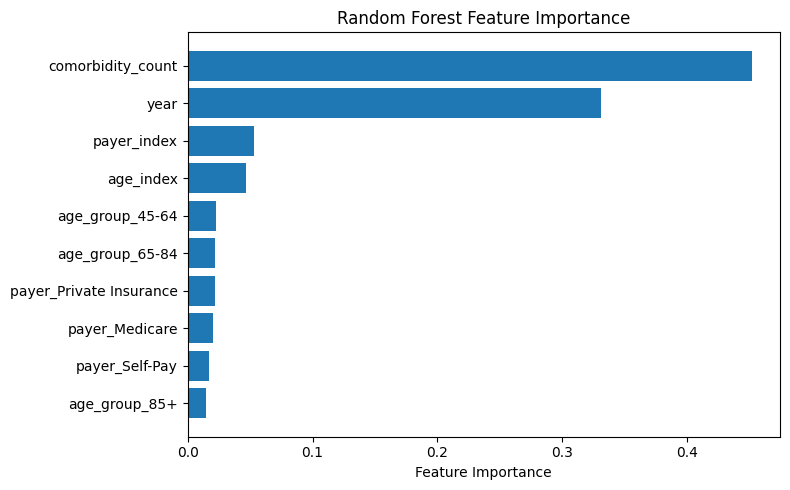

In [0]:
import matplotlib.pyplot as plt

# Get feature names used in training
feature_names = X_train.select_dtypes(include=["number", "bool"]).columns
importances = clf.feature_importances_

# Sort and plot importances
sorted_idx = importances.argsort()

plt.figure(figsize=(8, 5))
plt.barh(feature_names[sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


In [0]:
# Predict class probabilities for the positive class
X_test_encoded = X_test.select_dtypes(include=["number", "bool"]).copy()
probs = clf.predict_proba(X_test_encoded)[:, 1]

# Apply a lower threshold to increase recall
y_pred_thresh = (probs > 0.3).astype(int)

# Evaluate
print("Classification Report (Threshold = 0.3):\n", classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


Classification Report (Threshold = 0.3):
               precision    recall  f1-score   support

           0       0.87      0.32      0.47      2142
           1       0.15      0.71      0.25       358

    accuracy                           0.38      2500
   macro avg       0.51      0.51      0.36      2500
weighted avg       0.76      0.38      0.44      2500

Confusion Matrix:
 [[ 688 1454]
 [ 105  253]]


## 13. Threshold Tuning (Weighted RF)

To improve sensitivity for rare cases, we apply a custom probability threshold (e.g., 0.3 instead of default 0.5).  
This approach helps catch more positive readmission cases, which is especially important in healthcare risk modeling.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Select only numeric features (same as training earlier)
X_train_encoded = X_train.select_dtypes(include=["number", "bool"]).copy()
X_test_encoded = X_test.select_dtypes(include=["number", "bool"]).copy()

# Re-train with class_weight='balanced'
clf_weighted = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

clf_weighted.fit(X_train_encoded, y_train)

# Predict with default threshold (0.5)
y_pred = clf_weighted.predict(X_test_encoded)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.66      0.75      2142
           1       0.15      0.37      0.22       358

    accuracy                           0.62      2500
   macro avg       0.51      0.51      0.48      2500
weighted avg       0.76      0.62      0.67      2500

Confusion Matrix:
 [[1406  736]
 [ 226  132]]


In [0]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predicted probabilities from the weighted model
y_probs = clf_weighted.predict_proba(X_test_encoded)[:, 1]  # probability of class 1 (readmission)

# Apply custom threshold to increase sensitivity
threshold = 0.3
y_pred_thresh = (y_probs >= threshold).astype(int)

# Evaluate performance
print(f"Classification Report @ threshold = {threshold}")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))


Classification Report @ threshold = 0.3
              precision    recall  f1-score   support

           0       0.87      0.33      0.48      2142
           1       0.15      0.70      0.25       358

    accuracy                           0.39      2500
   macro avg       0.51      0.52      0.36      2500
weighted avg       0.77      0.39      0.45      2500

Confusion Matrix:
 [[ 715 1427]
 [ 108  250]]


## 14. Train XGBoost on Scaled Features

We now train an XGBoost model using `scale_pos_weight` to handle class imbalance.  
XGBoost generally performs better when input features are scaled or encoded numerically, and is especially useful for tabular classification problems like this one.

In [0]:
# Install XGBoost (for local Python or notebooks like Colab)
%pip install xgboost

# Prepare features (only numeric/boolean columns)
X_train_encoded = X_train.select_dtypes(include=["number", "bool"]).copy()
X_test_encoded = X_test.select_dtypes(include=["number", "bool"]).copy()

# Import and configure XGBoost
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Use scale_pos_weight to address class imbalance
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = xgb.XGBClassifier(
    scale_pos_weight=pos_weight,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Train and evaluate
model.fit(X_train_encoded, y_train)
y_pred = model.predict(X_test_encoded)

print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


/local_disk0/.ephemeral_nfs/envs/pythonEnv-a8e9f6b7-7c07-440e-8c26-a1f326beecd4/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [02:02:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.86      0.55      0.67      2142
           1       0.14      0.46      0.22       358

    accuracy                           0.54      2500
   macro avg       0.50      0.50      0.44      2500
weighted avg       0.76      0.54      0.61      2500

Confusion Matrix:
 [[1178  964]
 [ 195  163]]


## 15. XGBoost Feature Importance

We use gain-based importance to visualize the top contributing features.  
"Gain" refers to the improvement in accuracy brought by a feature to the branches it is on — useful for interpreting XGBoost decisions.

/home/spark-a8e9f6b7-7c07-440e-8c26-a1/.ipykernel/12329/command-7010289350593477-2990614584:7: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


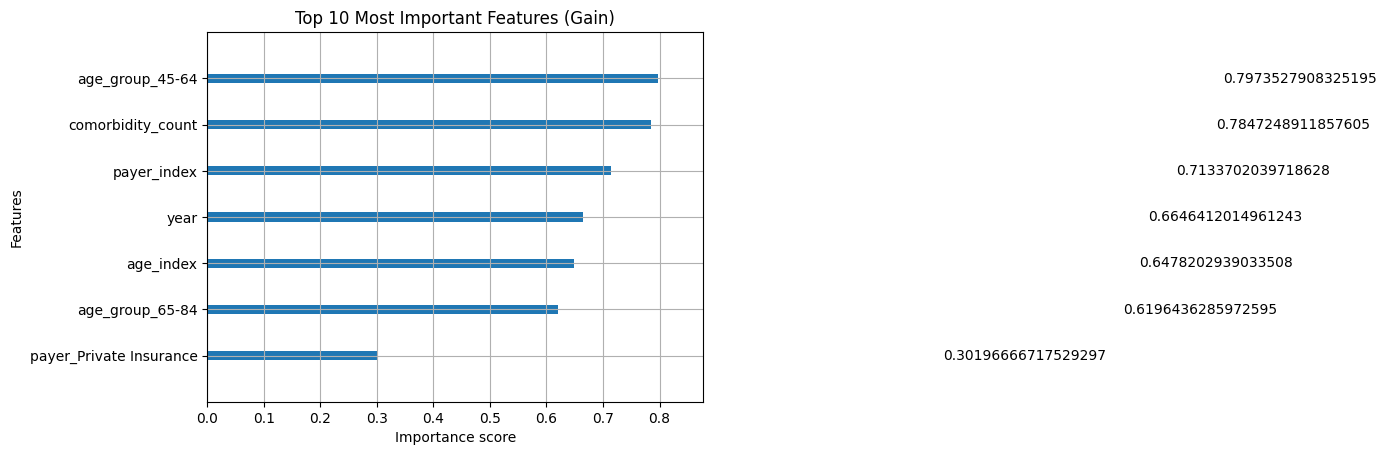

In [0]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot the top 10 most important features using "gain"
xgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Most Important Features (Gain)")
plt.tight_layout()
plt.show()



## 16. Precision-Recall Curve

To better tune thresholds, we analyze how precision and recall trade off against each other as the decision threshold shifts.  
This is especially helpful in imbalanced classification settings like readmission risk.

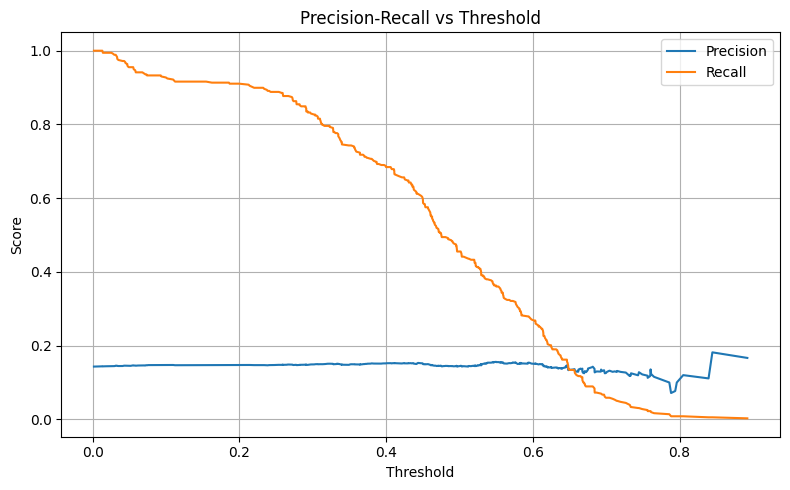

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_probs = model.predict_proba(X_test_encoded)[:, 1]

# Compute precision-recall metrics
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Plot precision and recall against threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 17. Final Evaluation with Custom Threshold

To increase sensitivity to hospital readmissions, we lower the threshold to 0.3 and evaluate performance.  
This shows how custom thresholds can impact metrics like recall and precision.

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

# Apply custom threshold to final XGBoost predictions
y_pred_custom = (y_probs >= 0.3).astype(int)

# Report metrics
print("Classification Report @ threshold = 0.3")
print(classification_report(y_test, y_pred_custom))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_custom))

Classification Report @ threshold = 0.3
              precision    recall  f1-score   support

           0       0.88      0.21      0.34      2142
           1       0.15      0.83      0.25       358

    accuracy                           0.30      2500
   macro avg       0.51      0.52      0.30      2500
weighted avg       0.78      0.30      0.33      2500

Confusion Matrix:
[[ 453 1689]
 [  62  296]]


## 18. Train XGBoost on Scaled Features

Now that we’ve built a strong baseline, we train XGBoost using only the numeric features most predictive of readmission.

XGBoost is sensitive to input scales, so we apply `StandardScaler`. To counter class imbalance, we dynamically tune `scale_pos_weight` using the training set’s class distribution. The final output is saved to a Delta table, making it queryable inside Superset for advanced visualizations.



In [0]:
# ✅ 1. Imports
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from collections import Counter
from pyspark.sql.functions import col

# ✅ 2. Select only numeric features for modeling
model_features = ['comorbidity_count', 'year']
X = df[model_features].copy()
y = df['label']

# ✅ 3. Keep full context for Superset output
X_full = df[['payer', 'age_group', 'comorbidity_count', 'year']].copy()

# ✅ 4. Train/Test Split (raw before scaling)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# ✅ 5. Scale numeric features for XGBoost
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# ✅ 6. Calculate class imbalance ratio for XGBoost
counter = Counter(y_train)
weight_ratio = counter[0] / counter[1]

# ✅ 7. Train XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=weight_ratio,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# ✅ 8. Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_probs = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ✅ 9. Format results for Superset integration
results_df = X_full.loc[X_test_raw.index].copy()
results_df['actual'] = y_test.values
results_df['predicted'] = y_pred
results_df['probability'] = y_probs

# ✅ 10. Convert to Spark DataFrame for Delta Lake
spark_df = spark.createDataFrame(results_df)

# ✅ 11. Ensure all fields are correctly typed
spark_df = spark_df.withColumn("payer", col("payer").cast("string"))
spark_df = spark_df.withColumn("age_group", col("age_group").cast("string"))

# ✅ 12. Write results to Delta Table (queryable in Superset)
spark.sql("DROP TABLE IF EXISTS xgboost_predictions_superset")
spark_df.write.mode("overwrite").saveAsTable("xgboost_predictions_superset")

print("✅ Saved to table: xgboost_predictions_superset (queryable in Superset)")


Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.57      0.68      2142
           1       0.15      0.44      0.22       358

    accuracy                           0.55      2500
   macro avg       0.50      0.51      0.45      2500
weighted avg       0.76      0.55      0.62      2500

Confusion Matrix:
 [[1216  926]
 [ 199  159]]
✅ Saved to table: xgboost_predictions_superset (queryable in Superset)


## 14. Format and Save Predictions

Load the XGBoost prediction table from Spark to preview results. This output includes predicted labels, probabilities, and input metadata, ready for use in Superset dashboards or further validation.


In [0]:
# ✅ Load the saved prediction table from Delta
df = spark.table("xgboost_predictions_superset")

# ✅ Preview results (queried from Delta Lake)
display(df)


payer age_group comorbidity_count year actual predicted probability Self-Pay 65-84 0 2020 0 1 0.54329795 Self-Pay 65-84 2 2022 0 0 0.4738592 Self-Pay 45-64 4 2022 0 1 0.5783353 Medicare 85+ 1 2019 0 0 0.4779106 Private Insurance 45-64 2 2021 0 1 0.55116737 Private Insurance 85+ 4 2023 0 0 0.47513774 Medicare 45-64 5 2022 0 0 0.4797405 Self-Pay 18-44 2 2021 0 1 0.55116737 Medi-Cal 45-64 2 2023 0 1 0.57108474 Self-Pay 85+ 2 2023 0 1 0.57108474 Medi-Cal 65-84 1 2019 0 0 0.4779106 Medi-Cal 85+ 5 2019 0 1 0.5058828 Self-Pay 18-44 2 2023 0 1 0.57108474 Self-Pay 65-84 1 2020 0 0 0.3668542 Medi-Cal 65-84 4 2021 1 0 0.45845842 Medicare 45-64 1 2022 0 0 0.4954694 Private Insurance 45-64 1 2021 0 0 0.43604308 Medi-Cal 18-44 5 2023 0 1 0.52688915 Self-Pay 45-64 2 2020 0 1 0.5418142 Self-Pay 18-44 2 2022 0 0 0.4738592 Private Insurance 18-44 5 2022 0 0 0.4797405 Medicare 18-44 0 2019 0 1 0.5902288 Medicare 45-64 3 2023 0 1 0.5432672 Medi-Cal 85+ 1 2021 0 0 0.43604308 Medicare 18-44 3 2019 1 0 0.48352268 Medi-Cal 18-44 1 2021 0 0 0.43604308 Medicare 65-84 5 2021 0 0 0.45295027 Private Insurance 65-84 0 2023 0 0 0.4855295 Medicare 65-84 0 2022 0 0 0.36280936 Medi-Cal 18-44 5 2022 1 0 0.4797405 Private Insurance 18-44 2 2019 0 0 0.4534725 Self-Pay 85+ 0 2019 0 1 0.5902288 Medicare 45-64 4 2021 0 0 0.45845842 Medicare 85+ 0 2022 1 0 0.36280936 Medi-Cal 18-44 4 2019 0 0 0.4955804 Medi-Cal 45-64 1 2023 0 1 0.51649904 Medicare 85+ 0 2019 0 1 0.5902288 Private Insurance 45-64 0 2023 0 0 0.4855295 Medicare 65-84 2 2023 0 1 0.57108474 Self-Pay 65-84 4 2023 1 0 0.47513774 Private Insurance 85+ 3 2023 1 1 0.5432672 Medicare 18-44 0 2020 0 1 0.54329795 Private Insurance 45-64 0 2020 1 1 0.54329795 Medicare 45-64 5 2019 0 1 0.5058828 Medicare 18-44 1 2023 0 1 0.51649904 Medicare 18-44 3 2019 0 0 0.48352268 Self-Pay 45-64 1 2019 1 0 0.4779106 Medi-Cal 65-84 5 2020 0 1 0.5180002 Medi-Cal 18-44 2 2021 0 1 0.55116737 Private Insurance 85+ 1 2022 0 0 0.4954694 Private Insurance 45-64 2 2023 1 1 0.57108474 Medicare 45-64 4 2019 0 0 0.4955804 Medicare 85+ 0 2023 0 0 0.4855295 Medicare 65-84 5 2023 1 1 0.52688915 Self-Pay 85+ 4 2021 1 0 0.45845842 Private Insurance 45-64 3 2023 0 1 0.5432672 Private Insurance 45-64 1 2019 0 0 0.4779106 Medi-Cal 65-84 1 2021 1 0 0.43604308 Medicare 45-64 3 2023 0 1 0.5432672 Medi-Cal 45-64 0 2020 0 1 0.54329795 Medicare 85+ 3 2022 0 0 0.4797874 Medicare 65-84 2 2023 0 1 0.57108474 Medicare 65-84 2 2019 0 0 0.4534725 Self-Pay 65-84 0 2023 0 0 0.4855295 Self-Pay 45-64 2 2022 0 0 0.4738592 Private Insurance 45-64 2 2019 0 0 0.4534725 Medicare 65-84 5 2021 0 0 0.45295027 Medi-Cal 85+ 4 2023 1 0 0.47513774 Private Insurance 65-84 5 2023 0 1 0.52688915 Medi-Cal 65-84 5 2022 1 0 0.4797405 Private Insurance 85+ 5 2019 0 1 0.5058828 Medi-Cal 65-84 2 2019 1 0 0.4534725 Private Insurance 85+ 2 2020 1 1 0.5418142 Private Insurance 45-64 0 2023 0 0 0.4855295 Medi-Cal 18-44 4 2019 0 0 0.4955804 Medicare 18-44 2 2019 0 0 0.4534725 Medi-Cal 65-84 1 2022 0 0 0.4954694 Private Insurance 65-84 2 2021 0 1 0.55116737 Private Insurance 18-44 2 2023 0 1 0.57108474 Self-Pay 85+ 4 2021 0 0 0.45845842 Private Insurance 65-84 2 2022 1 0 0.4738592 Medi-Cal 18-44 4 2021 0 0 0.45845842 Private Insurance 65-84 4 2023 0 0 0.47513774 Medicare 85+ 1 2023 0 1 0.51649904 Private Insurance 45-64 0 2020 1 1 0.54329795 Self-Pay 18-44 2 2022 0 0 0.4738592 Medicare 18-44 4 2019 0 0 0.4955804 Self-Pay 85+ 3 2023 0 1 0.5432672 Medi-Cal 65-84 5 2023 1 1 0.52688915 Medicare 18-44 0 2023 0 0 0.4855295 Medicare 18-44 4 2019 0 0 0.4955804 Private Insurance 45-64 0 2020 0 1 0.54329795 Private Insurance 85+ 5 2020 0 1 0.5180002 Self-Pay 18-44 1 2020 1 0 0.3668542 Medicare 85+ 4 2021 0 0 0.45845842 Medicare 65-84 0 2023 0 0 0.4855295 Medicare 65-84 0 2019 0 1 0.5902288 Medicare 85+ 5 2020 0 1 0.5180002 Medicare 65-84 5 2021 0 0 0.45295027 Private Insurance 45-64 3 2020 0 1 0.5303716 Medicare 18-44 0 2020 1 1 0.54329795 Medi-Cal 45-64 1 2019 0 0 0.4779106 Self-Pay 45-64 5 2023 0 

Databricks visualization. Run in Databricks to view.

## 15. Download Predictions as CSV (Optional)

Optionally export model predictions as a downloadable CSV for external sharing or offline analysis.


In [0]:
import base64
from io import BytesIO

# Convert results_df (Pandas) to in-memory CSV
csv_buffer = BytesIO()
results_df.to_csv(csv_buffer, index=False)
csv_bytes = csv_buffer.getvalue()

# Encode to base64 for safe browser download
csv_base64 = base64.b64encode(csv_bytes).decode()


In [0]:
from IPython.display import HTML

# Render download link inside notebook
download_link = f'''
<a download="xgboost_predictions.csv"
   href="data:text/csv;base64,{csv_base64}"
   target="_blank"
   style="font-size: 16px; font-weight: bold; color: #1a73e8;">
   📥 Download xgboost_predictions.csv
</a>
'''
HTML(download_link)


## 16. Conclusion

This project demonstrates how to build a full machine learning pipeline using PySpark, SMOTE, and XGBoost to simulate and predict hospital readmission risk based on synthetic healthcare data. The solution is optimized for Delta Lake storage and integrates seamlessly with Superset for interactive dashboarding.

### ✅ Techniques Used

- **PySpark** for scalable ETL and feature preparation
- **Synthetic data simulation** to mimic real-world class imbalance
- **Feature engineering** with categorical encoding and numeric extraction
- **Random Forest and XGBoost modeling**, including threshold and class-weight tuning
- **Delta table export** for downstream analytics in Superset

This notebook demonstrates not only technical fluency in big data tools, but also practical considerations like data export, dashboard integration, and model interpretability—key skills in modern data engineering and applied ML roles.
